In [ ]:
import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras as k

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

Filepath

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/COMP5703/resnet50_model.h5'

Testing GPU

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Update tuning on less classes but full nums of images

In [ ]:
from shutil import copy
import random
import collections
from collections import defaultdict

def get_data():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted successfully!")

def prepare_data(filepath, src, dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    #print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
get_data()

print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

4996278331/4996278331 [==============================] - 184s 0us/step
Dataset downloaded and extracted successfully!
Creating train data...
Copying Done!
Creating test data...
Copying Done!


## Get a mini-dataset

In [ ]:
from shutil import copytree, rmtree
def dataset_mini(food_list, src, dest):
  if not os.path.exists(dest):
    os.makedirs(dest)   #Make a directory if it does not exists
  for food_item in food_list :
    #print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
food_list = ['apple_pie','cannoli','dumplings', 'miso_soup', 'sushi']
src_train = 'food-101/train'
train_dir = 'food-101/train_mini'
src_test = 'food-101/test'
test_dir = 'food-101/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, train_dir)

print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, test_dir)

Creating train data folder with new classes
Creating test data folder with new classes


In [ ]:
N_CLASS = 5
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
def create_validation_set(src_train, dest_val, split_ratio=0.2):
    # Make a directory for the validation set if it does not exist
    if not os.path.exists(dest_val):
        os.makedirs(dest_val)

    for food_item in food_list:
        src_food_item = os.path.join(src_train, food_item)
        dest_food_item = os.path.join(dest_val, food_item)

        if not os.path.exists(dest_food_item):
            os.makedirs(dest_food_item)

        # List all image files in the source food category
        image_files = os.listdir(src_food_item)

        # Calculate the number of images to move to the validation set
        num_images_to_move = int(len(image_files) * split_ratio)

        # Randomly select images to move
        images_to_move = random.sample(image_files, num_images_to_move)

        # Move the selected images to the validation set directory
        for image in images_to_move:
            src_image = os.path.join(src_food_item, image)
            dest_image = os.path.join(dest_food_item, image)
            os.rename(src_image, dest_image)

# Define the path for the validation set
val_dir = 'food-101/validation_mini'

# Split a portion of the training data into the validation set
create_validation_set(train_dir, val_dir, split_ratio=0.2)

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

print("Training images:")
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMAGE_SHAPE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

print("Validation images:")
validation_generator = test_datagen.flow_from_directory(val_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=True)

Training images:
Found 3000 images belonging to 5 classes.
Validation images:
Found 750 images belonging to 5 classes.
Test images:
Found 1250 images belonging to 5 classes.


# Model

In [ ]:
resnet50 = ResNet50(weights='imagenet', include_top=False)

In [ ]:
model = Sequential()
model.add(resnet50)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(N_CLASS, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_12 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_12 (Dense)            (None, 128)               262272    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                      

## Unfreeze last layer only

In [ ]:
resnet50.trainable = True
for layer in resnet50.layers[:143]: #unfreezed the last layer conv_5
  layer.trainable = False

In [ ]:
len(model.trainable_variables)

52

In [ ]:
for i, layer in enumerate(resnet50.layers) :
  print(i, layer.name,layer.trainable)

In [ ]:
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_list = [callbacks.ModelCheckpoint(
        filepath = PATH,
        monitor = 'val_loss',
        save_best_only = True),
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.1,
            patience=2,
            mode='auto',
            min_delta=0.002,
            min_lr=1e-8),
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0.001,
            patience=3,
            verbose=1,
            mode='auto',
            baseline=None)]


In [ ]:
history = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks = callbacks_list)

<ipython-input-116-f931314fdda9>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/10
94/94 [==============================] - ETA: 0s - loss: 1.6711 - accuracy: 0.3107

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 61s 574ms/step - loss: 1.6711 - accuracy: 0.3107 - val_loss: 5.1004 - val_accuracy: 0.2000 - lr: 0.0100
Epoch 2/10
94/94 [==============================] - 63s 672ms/step - loss: 1.4181 - accuracy: 0.3830 - val_loss: 2.1320 - val_accuracy: 0.2053 - lr: 0.0100
Epoch 3/10
94/94 [==============================] - 53s 557ms/step - loss: 1.3663 - accuracy: 0.4303 - val_loss: 1.5495 - val_accuracy: 0.3213 - lr: 0.0100
Epoch 4/10
94/94 [==============================] - 56s 594ms/step - loss: 1.3392 - accuracy: 0.4420 - val_loss: 1.4281 - val_accuracy: 0.3813 - lr: 0.0100
Epoch 5/10
94/94 [==============================] - 52s 553ms/step - loss: 1.3263 - accuracy: 0.4530 - val_loss: 2.6504 - val_accuracy: 0.2133 - lr: 0.0100
Epoch 6/10
94/94 [==============================] - 48s 506ms/step - loss: 1.2962 - accuracy: 0.4777 - val_loss: 1.4700 - val_accuracy: 0.3827 - lr: 0.0100
Epoch 7/10
94/94 [==============================] - 51s 547ms/step - loss: 

In [ ]:
def draw_plot(acc, val_acc, loss, val_loss):

  plt.figure(1, figsize = (15,8))

  plt.subplot(221)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'])

  plt.subplot(222)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'])

  plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

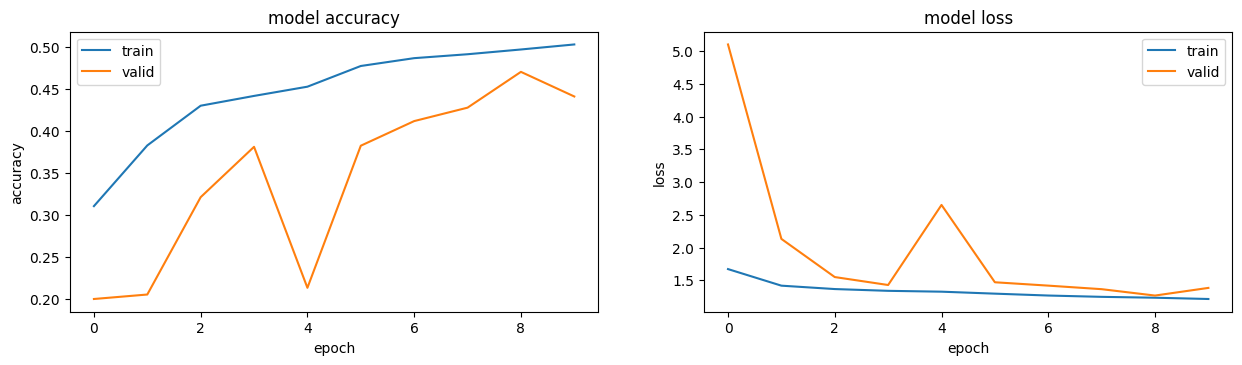

In [ ]:
draw_plot(acc, val_acc, loss, val_loss)

## Tune tune tuna conv4 + conv5

In [ ]:
resnet50.trainable = True
for layer in resnet50.layers[:81]: #unfreezed the last 2 layer conv_4 + conv_5
  layer.trainable = False

In [ ]:
len(model.trainable_variables)

128

In [ ]:
for i, layer in enumerate(resnet50.layers) :
  print(i, layer.name,layer.trainable)

In [ ]:
fine_tune_epochs = 20
total_epochs =  EPOCHS + fine_tune_epochs

In [ ]:
history_fine = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    verbose=1,
                    callbacks = callbacks_list)

<ipython-input-126-9726b128c753>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_fine = model.fit_generator(train_generator,


Epoch 10/30
94/94 [==============================] - 48s 514ms/step - loss: 1.2345 - accuracy: 0.5067 - val_loss: 1.2379 - val_accuracy: 0.4880 - lr: 1.0000e-03
Epoch 11/30
94/94 [==============================] - 49s 519ms/step - loss: 1.2203 - accuracy: 0.5017 - val_loss: 1.2782 - val_accuracy: 0.4800 - lr: 1.0000e-03
Epoch 12/30
94/94 [==============================] - 50s 534ms/step - loss: 1.2054 - accuracy: 0.5177 - val_loss: 1.2785 - val_accuracy: 0.4560 - lr: 1.0000e-03
Epoch 13/30
94/94 [==============================] - 51s 537ms/step - loss: 1.2061 - accuracy: 0.5203 - val_loss: 1.1417 - val_accuracy: 0.5413 - lr: 1.0000e-04
Epoch 14/30
94/94 [==============================] - 57s 610ms/step - loss: 1.1979 - accuracy: 0.5120 - val_loss: 1.1173 - val_accuracy: 0.5640 - lr: 1.0000e-04
Epoch 15/30
94/94 [==============================] - 58s 618ms/step - loss: 1.2008 - accuracy: 0.5080 - val_loss: 1.1059 - val_accuracy: 0.5720 - lr: 1.0000e-04
Epoch 16/30
94/94 [===============

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

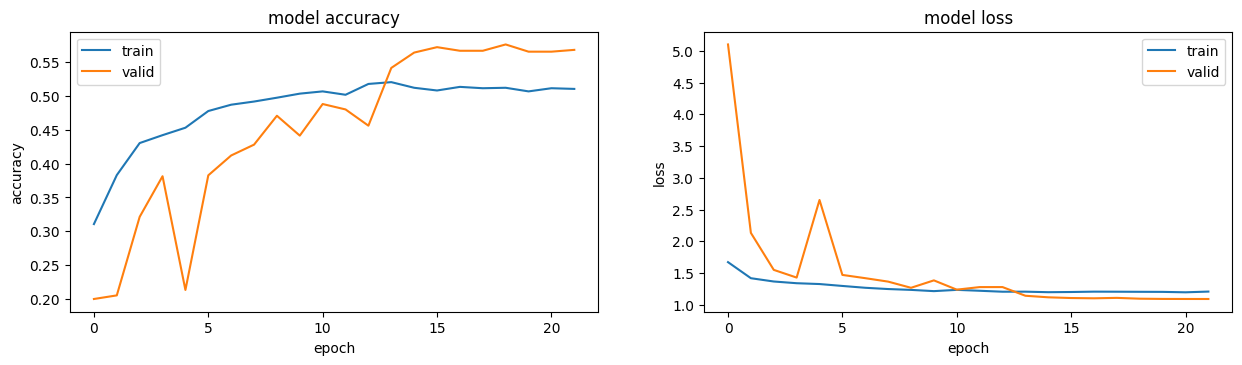

In [ ]:
draw_plot(acc, val_acc, loss, val_loss)

## Unfreeze conv_3

In [ ]:
resnet50.trainable = True
for layer in resnet50.layers[:39]: #unfreezed the last 3 layers
  layer.trainable = False

In [ ]:
len(model.trainable_variables)

180

In [ ]:
for i, layer in enumerate(resnet50.layers) :
  print(i, layer.name,layer.trainable)

In [ ]:
total_epochs += fine_tune_epochs

In [ ]:
history_fine_all = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=total_epochs,
                    initial_epoch=history_fine.epoch[-1],
                    verbose=1,
                    callbacks = callbacks_list)

<ipython-input-135-68dbd53ca05a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_fine_all = model.fit_generator(train_generator,


Epoch 21/50
94/94 [==============================] - 48s 515ms/step - loss: 1.2033 - accuracy: 0.5190 - val_loss: 1.0908 - val_accuracy: 0.5693 - lr: 1.0000e-06
Epoch 22/50
94/94 [==============================] - 49s 518ms/step - loss: 1.2045 - accuracy: 0.5233 - val_loss: 1.0906 - val_accuracy: 0.5680 - lr: 1.0000e-06
Epoch 23/50
94/94 [==============================] - 50s 536ms/step - loss: 1.2003 - accuracy: 0.5207 - val_loss: 1.0905 - val_accuracy: 0.5680 - lr: 1.0000e-06
Epoch 24/50
94/94 [==============================] - ETA: 0s - loss: 1.2058 - accuracy: 0.5163

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 49s 525ms/step - loss: 1.2058 - accuracy: 0.5163 - val_loss: 1.0904 - val_accuracy: 0.5680 - lr: 1.0000e-07
Epoch 24: early stopping


In [ ]:
acc += history_fine_all.history['accuracy']
val_acc += history_fine_all.history['val_accuracy']

loss += history_fine_all.history['loss']
val_loss += history_fine_all.history['val_loss']

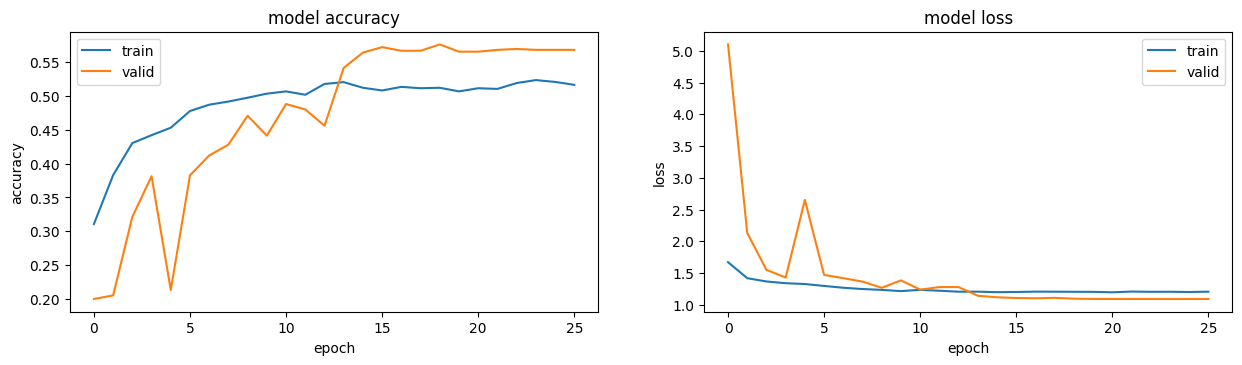

In [ ]:
draw_plot(acc, val_acc, loss, val_loss)

## Unfreeze all

In [ ]:
resnet50.trainable = True

In [ ]:
len(model.trainable_variables)

224

In [ ]:
fine_tune_epochs = 10
total_epochs += fine_tune_epochs

In [ ]:
model.compile(optimizer=SGD(lr=0.01, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
callbacks_list = [callbacks.ModelCheckpoint(
        filepath = PATH,
        monitor = 'val_accuracy',
        save_best_only = True),
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.1,
            patience=2,
            mode='max',
            min_delta=0.002,
            min_lr=1e-8),
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            min_delta=0.0007,
            patience=4,
            verbose=1,
            mode='max',
            baseline=None)]


history_all = model.fit_generator(train_generator,
                    validation_data=validation_generator,
                    epochs=total_epochs,
                    initial_epoch=history_fine_all.epoch[-1],
                    verbose=1,
                    callbacks = callbacks_list)

<ipython-input-141-7acfaaea2ce3>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_all = model.fit_generator(train_generator,


Epoch 24/60
94/94 [==============================] - ETA: 0s - loss: 0.6321 - accuracy: 0.7810

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


94/94 [==============================] - 76s 638ms/step - loss: 0.6321 - accuracy: 0.7810 - val_loss: 1.9044 - val_accuracy: 0.2013 - lr: 0.0100
Epoch 25/60
94/94 [==============================] - 58s 615ms/step - loss: 0.5095 - accuracy: 0.8157 - val_loss: 1.8596 - val_accuracy: 0.2000 - lr: 0.0100
Epoch 26/60
94/94 [==============================] - 56s 590ms/step - loss: 0.4360 - accuracy: 0.8457 - val_loss: 2.0379 - val_accuracy: 0.2000 - lr: 0.0100
Epoch 27/60
94/94 [==============================] - 61s 642ms/step - loss: 0.3723 - accuracy: 0.8753 - val_loss: 1.9281 - val_accuracy: 0.2040 - lr: 1.0000e-03
Epoch 28/60
94/94 [==============================] - 63s 672ms/step - loss: 0.2790 - accuracy: 0.9117 - val_loss: 1.9045 - val_accuracy: 0.2573 - lr: 1.0000e-03
Epoch 29/60
94/94 [==============================] - 65s 689ms/step - loss: 0.2577 - accuracy: 0.9187 - val_loss: 1.4530 - val_accuracy: 0.4053 - lr: 1.0000e-03
Epoch 30/60
94/94 [==============================] - 64s 6

In [ ]:
acc_all = history_all.history['accuracy']
val_acc_all = history_all.history['val_accuracy']

loss_all = history_all.history['loss']
val_loss_all = history_all.history['val_loss']

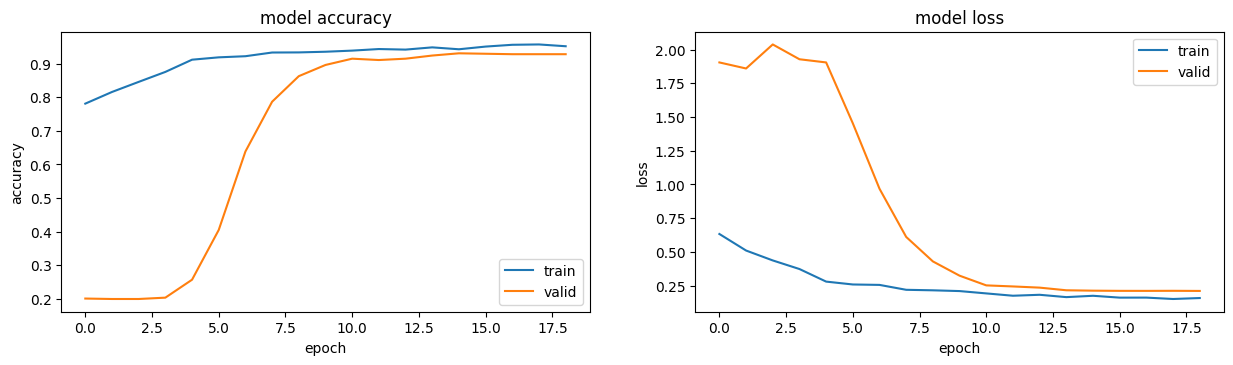

In [ ]:
draw_plot(acc_all, val_acc_all, loss_all, val_loss_all)

In [ ]:
model.save(PATH)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Last thing last - test evaluation

In [ ]:
print("Test images:")
test_generator = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode='categorical',
                                                        shuffle=False,
                                                        seed = 123)

Test images:
Found 1250 images belonging to 5 classes.


In [ ]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy and loss :', accuracy, loss)

40/40 [==============================] - 5s 112ms/step - loss: 0.1490 - accuracy: 0.9480
Test accuracy and loss : 0.9480000138282776 0.1489914506673813


In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

<ipython-input-175-b1c17ed9393b>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Classification Report
              precision    recall  f1-score   support

   apple_pie       0.91      0.90      0.91       250
     cannoli       0.93      0.93      0.93       250
   dumplings       0.96      0.96      0.96       250
   miso_soup       0.98      0.98      0.98       250
       sushi       0.95      0.96      0.96       250

    accuracy                           0.95      1250
   macro avg       0.95      0.95      0.95      1250
weighted avg       0.95      0.95      0.95      1250



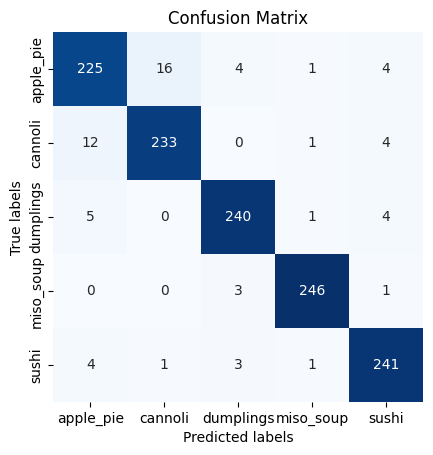

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(test_generator.classes, y_pred)
ax = plt.subplot()
sns.heatmap(cm, square=True, annot=True, cmap='Blues', fmt='d', cbar=False,ax=ax)
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(food_list); ax.yaxis.set_ticklabels(food_list);

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=food_list))
